### HW13 PipeLine & Explainable AI
### Kiarash Gheisari Pour - 402102302

we'll use the dermatology dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### DATALOADING Pipeline

In [3]:
import pandas as pd
import numpy as np

def load_and_clean_dermatology_data(filepath='dermatology.data'):
    columns = [
        "erythema", "scaling", "definite_borders", "itching", "koebner_phenomenon", "polygonal_papules",
        "follicular_papules", "oral_mucosal_involvement", "knee_and_elbow_involvement", "scalp_involvement",
        "family_history", "melanin_incontinence", "eosinophils_in_the_infiltrate", "PNL_infiltrate",
        "fibrosis_of_the_papillary_dermis", "exocytosis", "acanthosis", "hyperkeratosis", "parakeratosis",
        "clubbing_of_the_rete_ridges", "elongation_of_the_rete_ridges", "thinning_of_the_suprapapillary_epidermis",
        "spongiform_pustule", "munro_microabcess", "focal_hypergranulosis", "disappearance_of_the_granular_layer",
        "vacuolisation_and_damage_of_basal_layer", "spongiosis", "saw_tooth_appearance_of_retes",
        "follicular_horn_plug", "perifollicular_parakeratosis", "inflammatory_monoluclear_inflitrate",
        "band_like_infiltrate", "age", "class"
    ]

    df = pd.read_csv(filepath, header=None, na_values='?')

    df.columns = columns

    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    median_age = df['age'].median()
    df['age'].fillna(median_age, inplace=True)

    for col in df.columns:
        if df[col].isnull().any():
            if col != 'age':
                mode_value = df[col].mode()[0]
                df[col].fillna(mode_value, inplace=True)
                df[col] = df[col].astype(int)

    feature_columns = [col for col in columns if col not in ['age', 'class']]
    for col in feature_columns:
         df[col] = pd.to_numeric(df[col], errors='coerce')
         df[col] = df[col].astype(int)

    df['class'] = df['class'].astype(int)

    print("Data loading and cleaning complete.")
    print("DataFrame Info after cleaning:")
    df.info()
    print("\nMissing values after cleaning:")
    print(df.isnull().sum())

    return df


In [4]:
df = load_and_clean_dermatology_data('dermatology.data')

Data loading and cleaning complete.
DataFrame Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   erythema                                  366 non-null    int64  
 1   scaling                                   366 non-null    int64  
 2   definite_borders                          366 non-null    int64  
 3   itching                                   366 non-null    int64  
 4   koebner_phenomenon                        366 non-null    int64  
 5   polygonal_papules                         366 non-null    int64  
 6   follicular_papules                        366 non-null    int64  
 7   oral_mucosal_involvement                  366 non-null    int64  
 8   knee_and_elbow_involvement                366 non-null    int64  
 9   scalp_involvement                         

C:\Users\darkoob\AppData\Local\Temp\ipykernel_2996\2972920256.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(median_age, inplace=True)


### PreProcessing Pipeline

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer



X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Original X shape: {X.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

feature_columns_for_scaling = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), feature_columns_for_scaling)
    ],
    remainder='passthrough' # In case there are columns not specified (none here)
)


preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

preprocessing_pipeline.fit(X_train)


X_train_processed = preprocessing_pipeline.transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

print("\nShape of X_train_processed:", X_train_processed.shape)
print("Shape of X_test_processed:", X_test_processed.shape)



Original X shape: (366, 34)
X_train shape: (292, 34)
X_test shape: (74, 34)

Shape of X_train_processed: (292, 34)
Shape of X_test_processed: (74, 34)


### Pipeline with classifier
we didn't have any missing data so no imputing


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

full_pipeline.fit(X_train, y_train)

y_pred = full_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Model Accuracy: {accuracy:.4f}")



Shape of X_train: (292, 34)
Shape of X_test: (74, 34)
Model Accuracy: 0.9865


### undersampling

In [7]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

print("Original training set shape:", X_train.shape)
print("Original training set class distribution:", Counter(y_train))

rus = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("\nResampled training set shape:", X_train_resampled.shape)
print("Resampled training set class distribution:", Counter(y_train_resampled))


Original training set shape: (292, 34)
Original training set class distribution: Counter({1: 81, 3: 59, 2: 52, 5: 42, 4: 41, 6: 17})

Resampled training set shape: (102, 34)
Resampled training set class distribution: Counter({1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17})


### OverSampling

In [9]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

print("Original training set shape:", X_train.shape)
print("Original training set class distribution:", Counter(y_train))

ros = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("\nResampled training set shape:", X_train_resampled.shape)
print("Resampled training set class distribution:", Counter(y_train_resampled))

Original training set shape: (292, 34)
Original training set class distribution: Counter({1: 81, 3: 59, 2: 52, 5: 42, 4: 41, 6: 17})

Resampled training set shape: (102, 34)
Resampled training set class distribution: Counter({1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17})


### SMOTE

In [10]:
# Add after your existing oversampling sections:

from imblearn.over_sampling import SMOTE

print("\n--- SMOTE Oversampling ---")
print("Original training set shape:", X_train.shape)
print("Original training set class distribution:", Counter(y_train))

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nSMOTE resampled training set shape:", X_train_smote.shape)
print("SMOTE resampled training set class distribution:", Counter(y_train_smote))


--- SMOTE Oversampling ---
Original training set shape: (292, 34)
Original training set class distribution: Counter({1: 81, 3: 59, 2: 52, 5: 42, 4: 41, 6: 17})

SMOTE resampled training set shape: (486, 34)
SMOTE resampled training set class distribution: Counter({5: 81, 2: 81, 1: 81, 4: 81, 3: 81, 6: 81})


### Cost-Sensitive Learning with Class Weights"  

In [11]:

print("\n--- Cost-Sensitive Learning with Sample Weights ---")
print("Original training set class distribution:", Counter(y_train))

from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights based on class frequencies
# 'balanced' automatically assigns weights inversely proportional to class frequencies
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train,
)

# Print the first few sample weights
print("First 10 sample weights:", sample_weights[:10])

# Display weight distribution by class
for class_label in np.unique(y_train):
    class_indices = np.where(y_train == class_label)[0]
    avg_weight = np.mean(sample_weights[class_indices])
    print(f"Average weight for class {class_label}: {avg_weight:.4f} (count: {len(class_indices)})")

# These weights can be used in model.fit() with the sample_weight parameter
# model.fit(X_train, y_train, sample_weight=sample_weights)


--- Cost-Sensitive Learning with Sample Weights ---
Original training set class distribution: Counter({1: 81, 3: 59, 2: 52, 5: 42, 4: 41, 6: 17})
First 10 sample weights: [1.15873016 1.15873016 0.93589744 1.15873016 1.15873016 0.93589744
 0.60082305 1.18699187 0.82485876 0.82485876]
Average weight for class 1: 0.6008 (count: 81)
Average weight for class 2: 0.9359 (count: 52)
Average weight for class 3: 0.8249 (count: 59)
Average weight for class 4: 1.1870 (count: 41)
Average weight for class 5: 1.1587 (count: 42)
Average weight for class 6: 2.8627 (count: 17)


### EXPLAINABLE AI

In [ ]:
# 1. Load and preprocess MNIST dataset
(x_train_full, y_train_full), _ = mnist.load_data()
x_train_full = x_train_full.astype('float32') / 255.0
x_train_full = np.expand_dims(x_train_full, -1)  # shape: (n_samples, 28, 28, 1)
y_train_full = to_categorical(y_train_full, 10)  # one-hot encoding

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# 1. Load and preprocess MNIST dataset
(x_train_full, y_train_full), _ = mnist.load_data()
x_train_full = x_train_full.astype('float32') / 255.0
x_train_full = np.expand_dims(x_train_full, -1)  # shape: (n_samples, 28, 28, 1)
y_train_full = to_categorical(y_train_full, 10)  # one-hot encoding

# 2. Define a function to create the CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 3. Perform 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []

for train_idx, val_idx in kf.split(x_train_full):
    print(f"\nTraining on Fold {fold_no}...")

    x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = create_model()
    model.fit(x_train, y_train, epochs=3, batch_size=64, verbose=1,
              validation_data=(x_val, y_val))

    scores = model.evaluate(x_val, y_val, verbose=0)
    print(f"Fold {fold_no} Accuracy: {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1] * 100)

    fold_no += 1

# Print average accuracy
print(f"\nAverage accuracy across 3 folds: {np.mean(acc_per_fold):.2f}%")



Training on Fold 1...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 69ms/step - accuracy: 0.8487 - loss: 0.5051 - val_accuracy: 0.9779 - val_loss: 0.0713
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9792 - loss: 0.0658 - val_accuracy: 0.9847 - val_loss: 0.0489
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 73ms/step - accuracy: 0.9881 - loss: 0.0399 - val_accuracy: 0.9862 - val_loss: 0.0465
Fold 1 Accuracy: 98.62%

Training on Fold 2...
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 68ms/step - accuracy: 0.8277 - loss: 0.5589 - val_accuracy: 0.9678 - val_loss: 0.1049
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.9761 - loss: 0.0727 - val_accuracy: 0.9833 - val_loss: 0.0550
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.9861 - loss: 0.0452 - val_accuracy: 0.9865 - val_loss: 0.0459
Fold 2 Accuracy: 98.65%

Training on Fold 3...
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 70ms/step - accuracy: 0.8412 - loss: 0.5284 - val_accuracy: 0.9768 - val_loss: 0.0772
Epo

### SHAP

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
True label: 9, Predicted label: 5
shap_values.shape = (1, 28, 28, 1, 10)


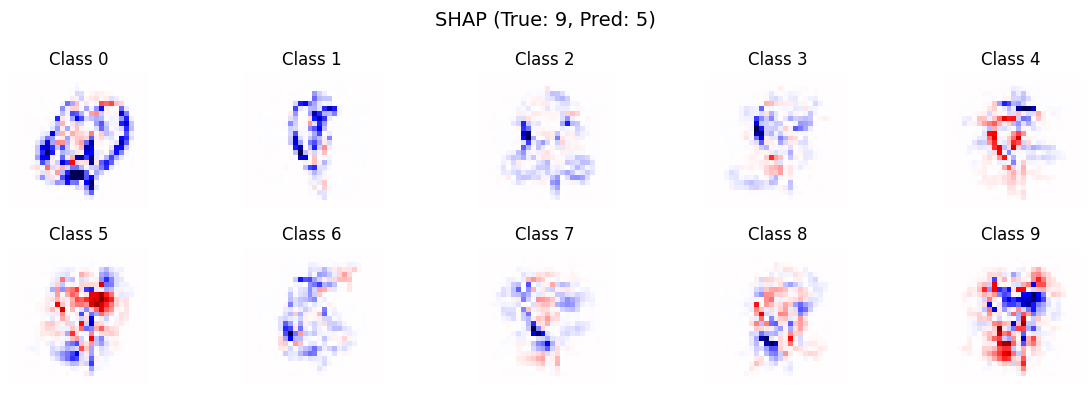

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap

(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1)  # Shape: (num_samples, 28, 28, 1)
preds = model.predict(x_test)
pred_labels = np.argmax(preds, axis=1)
misclassified_indices = np.where(pred_labels != y_test)[0]

if len(misclassified_indices) == 0:
    print("No misclassified images found.")
    exit()

idx = misclassified_indices[0]
img = x_test[idx:idx+1]
true_label = y_test[idx]
pred_label = pred_labels[idx]

print(f"True label: {true_label}, Predicted label: {pred_label}")

# --- SHAP GradientExplainer setup ---
# Use a small subset of test data as background for SHAP
background = x_test[np.random.choice(x_test.shape[0], 100, replace=False)]

explainer = shap.GradientExplainer(model, background)

# --- Compute SHAP values for the misclassified image ---
shap_values = explainer.shap_values(img)
print(f"shap_values.shape = {np.array(shap_values).shape}")

# --- Visualize SHAP values ---
# Plot SHAP heatmaps for each class (we care about the predicted class most)
plt.figure(figsize=(12, 4))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    shap_img = shap_values[0, :, :, 0, i]  # Extract 2D SHAP map for class i

    plt.imshow(shap_img, cmap='seismic',
               vmin=-np.max(np.abs(shap_img)),
               vmax=np.max(np.abs(shap_img)))
    plt.title(f"Class {i}")
    plt.axis('off')

plt.suptitle(f"SHAP (True: {true_label}, Pred: {pred_label})", fontsize=14)
plt.tight_layout()
plt.show()


plt.suptitle(f"SHAP explanations for misclassified digit (True: {true_label}, Pred: {pred_label})", fontsize=14)
plt.tight_layout()
plt.show()


### LIME

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
True label: 9, Predicted label: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

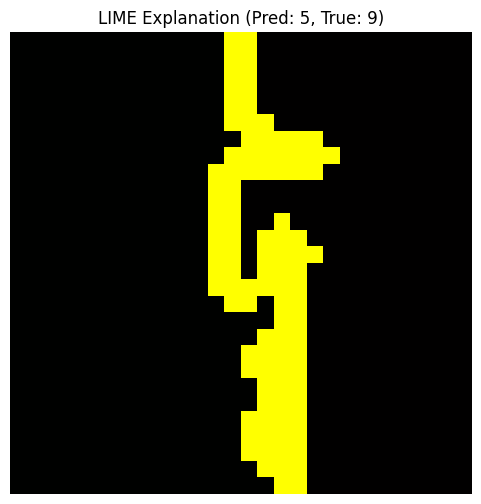

In [ ]:
from lime import lime_image
from skimage.color import gray2rgb
from skimage.segmentation import mark_boundaries

# --- Load test data ---
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1)

# --- Find a misclassified example ---
preds = model.predict(x_test)
pred_labels = np.argmax(preds, axis=1)
misclassified_indices = np.where(pred_labels != y_test)[0]

if len(misclassified_indices) == 0:
    print("No misclassified examples found.")
    exit()

idx = misclassified_indices[0]
img = x_test[idx]
true_label = y_test[idx]
pred_label = pred_labels[idx]

print(f"True label: {true_label}, Predicted label: {pred_label}")

# --- Prepare image for LIME (RGB) ---
img_rgb = gray2rgb(np.squeeze(img))  # Shape: (28, 28, 3)

# --- LIME explainer setup ---
explainer = lime_image.LimeImageExplainer()

# LIME expects a function that outputs probabilities
def predict_fn(images):
    # Convert RGB to grayscale and add channel
    images = np.mean(images, axis=-1, keepdims=True)
    return model.predict(images)

# --- Explain prediction ---
explanation = explainer.explain_instance(
    img_rgb,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# --- Get image and mask for the predicted class ---
temp, mask = explanation.get_image_and_mask(
    label=pred_label,
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# --- Visualize ---
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation (Pred: {pred_label}, True: {true_label})")
plt.axis('off')
plt.show()